In [1]:
import wandb
import sys
import warnings
from pathlib import Path
import optuna
import pandas as pd

import os
import sys

from otc.features.build_features import (
    features_categorical,
    features_classical,
    features_classical_size,
    features_ml,
)

from __future__ import annotations

from typing import Any, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from tqdm.auto import tqdm

In [2]:
EXCHANGE = "ise"
STRATEGY = "supervised"

In [3]:
dataset = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_none:latest"

os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

run = wandb.init(project="thesis", entity="fbv")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


In [4]:
# download labelled
artifact_labelled = run.use_artifact(dataset)
artifact_dir_labelled = artifact_labelled.download()

# download unlabelled
unlabelled_dataset = dataset.replace("supervised", "unsupervised")
artifact_unlabelled = run.use_artifact(unlabelled_dataset)
artifact_dir_unlabelled = artifact_unlabelled.download()

x_train_unlabelled = pd.read_parquet(
            Path(artifact_dir_unlabelled, "train_set.parquet"), columns=["buy_sell", *features_classical_size]
        )

# labelled data
x_train_labelled = pd.read_parquet(
            Path(artifact_dir_labelled, "train_set.parquet"), columns=["buy_sell", *features_classical_size]
)

x_train_unlabelled["src"] = "unlabelled"
x_train_labelled["src"] = "labelled"


# load unscaled data
# artifact_labelled = run.use_artifact(dataset)
# artifact_dir_labelled = artifact_labelled.download()
# x_train = pd.concat([x_train_labelled, x_train_unlabelled])
# y_train = pd.concat([y_train_labelled, y_train_unlabelled])

wandb: Downloading large artifact ise_supervised_none:latest, 4203.92MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.1
wandb: Downloading large artifact ise_unsupervised_none:latest, 1076.86MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.3


In [5]:
x_train_unlabelled.head().T

index_labelled,2.724860e+07,2.724860e+07,2.724860e+07,2.724860e+07,2.724860e+07
buy_sell,0,0,0,0,0
TRADE_PRICE,0.45,0.47,1.86,2.02,3.03
bid_ex,NaN,NaN,NaN,1.82,2.99
ask_ex,NaN,NaN,NaN,2.02,3.1
BEST_ASK,0.0,0.62,0.0,2.02,3.1
BEST_BID,0.0,0.55,0.0,1.82,2.99
price_ex_lag,NaN,0.76,1.83,1.9,3.27
price_ex_lead,0.67,0.56,1.8,1.88,3.26
price_all_lag,NaN,0.57,1.87,1.89,3.2
price_all_lead,0.4,0.55,1.76,1.86,3.07


In [6]:
x_train_unlabelled.index.min()

27248577.4

In [7]:
x_train_unlabelled.index.max()

29510319.0

In [8]:
# slice to same time range as unlabelled trades
x_train_labelled = x_train_labelled.iloc[27248577 : 29510319]

In [9]:
x_train_labelled

,buy_sell,TRADE_PRICE,bid_ex,ask_ex,BEST_ASK,BEST_BID,price_ex_lag,price_ex_lead,price_all_lag,price_all_lead,...,prox_ex,prox_best,bid_ask_size_ratio_ex,rel_bid_size_ex,rel_ask_size_ex,TRADE_SIZE,bid_size_ex,ask_size_ex,depth_ex,src
index,,,,,,,,,,,,,,,,,,,,,
27248600,-1,1.95,NaN,NaN,0.00,0.00,2.10,1.90,3.52,1.85,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,labelled
27248599,1,1.65,1.40,1.65,1.65,1.40,1.70,1.60,3.22,1.45,...,1.000000,1.000000,1.000000,0.047619,0.047619,1,21.0,21.0,0.0,labelled
27248601,1,1.65,1.40,1.65,1.65,1.40,1.70,1.60,3.22,1.45,...,1.000000,1.000000,1.000000,0.428571,0.428571,9,21.0,21.0,0.0,labelled
27248597,1,3.10,2.70,3.10,3.10,2.70,2.96,3.00,3.00,3.00,...,0.999999,0.999999,0.916667,0.045455,0.041667,1,22.0,24.0,-2.0,labelled
27248596,1,3.10,2.70,3.10,3.10,2.70,2.96,3.00,3.00,3.00,...,0.999999,0.999999,0.916667,0.090909,0.083333,2,22.0,24.0,-2.0,labelled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29510314,-1,0.50,0.49,0.53,0.53,0.49,0.53,0.47,0.54,0.47,...,-0.500000,-0.500000,1.701351,0.002648,0.004505,10,3777.0,2220.0,1557.0,labelled
29510315,-1,0.15,0.15,0.19,0.17,0.15,0.16,0.16,0.16,0.16,...,-1.000000,-0.999999,1.653846,1.000000,1.653846,43,43.0,26.0,17.0,labelled
29510316,1,0.60,0.56,0.60,0.60,0.56,0.72,0.47,0.72,0.42,...,0.999999,0.999999,0.500000,0.100000,0.050000,1,10.0,20.0,-10.0,labelled


In [10]:
data = pd.concat([x_train_labelled, x_train_unlabelled]).sample(frac=0.10)

In [20]:
def plot_kde_src(var_name: str, clip: List[float] | None = None):
    """
    Plot kde plots for labelled and unlabelled with regard to the feature 'var_name'.

    Args:
        var_name (str): name of feature
        clip (List[float] | None, optional): clipping range. Defaults to None.
    """

    quantiles = np.linspace(.1, 1, 9, 0)
    stats_unlabelled = data[data["src"] == "unlabelled"][var_name].quantile(quantiles)
    stats_labelled = data[data["src"] == "labelled"][var_name].quantile(quantiles)
    
    _, ax = plt.subplots()
    for i in ["unlabelled", "labelled"]:
        sns.kdeplot(
            data=data[data["src"] == i][var_name],
            clip=clip,
            label=str(i),
            cumulative=True,
            common_grid=True,
            # common_norm=True,
        )
    ax.title.set_text(f"Distribution of '{var_name}'")
    ax.legend()
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
    plt.show()

    stats = pd.concat([stats_unlabelled, stats_labelled], keys=["unlabelled", "labelled"], axis=1)
    print(stats)

In [21]:
data.columns

Index(['buy_sell', 'TRADE_PRICE', 'bid_ex', 'ask_ex', 'BEST_ASK', 'BEST_BID',
       'price_ex_lag', 'price_ex_lead', 'price_all_lag', 'price_all_lead',
       'chg_ex_lead', 'chg_ex_lag', 'chg_all_lead', 'chg_all_lag', 'prox_ex',
       'prox_best', 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',
       'rel_ask_size_ex', 'TRADE_SIZE', 'bid_size_ex', 'ask_size_ex',
       'depth_ex', 'src'],
      dtype='object')

  0%|          | 0/22 [00:00<?, ?it/s]

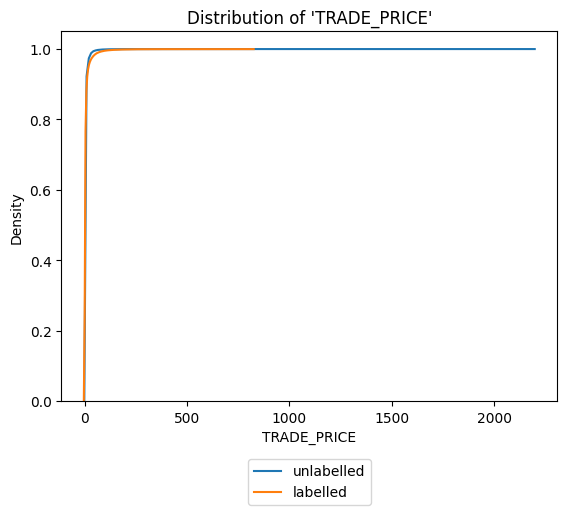

     unlabelled  labelled
0.1        0.18      0.10
0.2        0.38      0.28
0.3        0.61      0.52
0.4        0.90      0.86
0.5        1.25      1.32
0.6        1.74      2.00
0.7        2.46      3.09
0.8        3.81      4.98
0.9        7.60     10.01


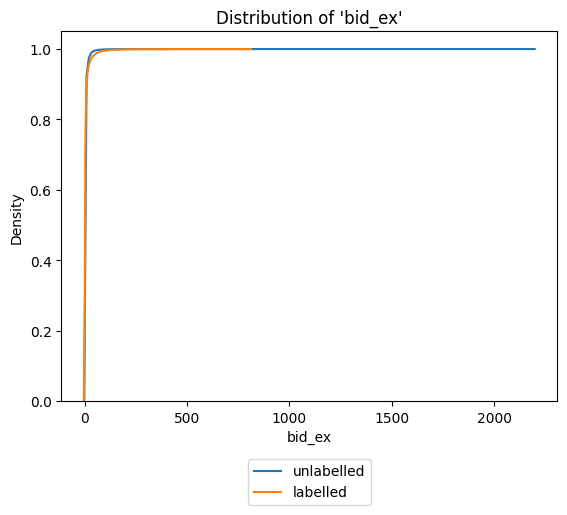

     unlabelled  labelled
0.1        0.15      0.07
0.2        0.35      0.25
0.3        0.58      0.49
0.4        0.86      0.80
0.5        1.21      1.25
0.6        1.70      1.95
0.7        2.40      3.00
0.8        3.70      4.82
0.9        7.40      9.80


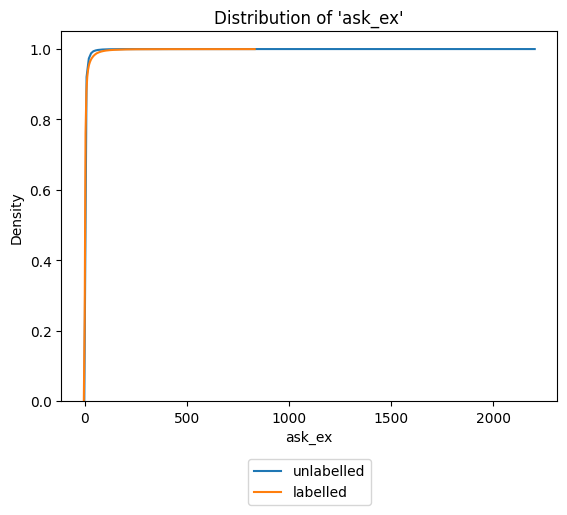

     unlabelled  labelled
0.1        0.20      0.13
0.2        0.40      0.30
0.3        0.64      0.56
0.4        0.93      0.91
0.5        1.29      1.39
0.6        1.80      2.10
0.7        2.53      3.20
0.8        3.92      5.10
0.9        7.77     10.20


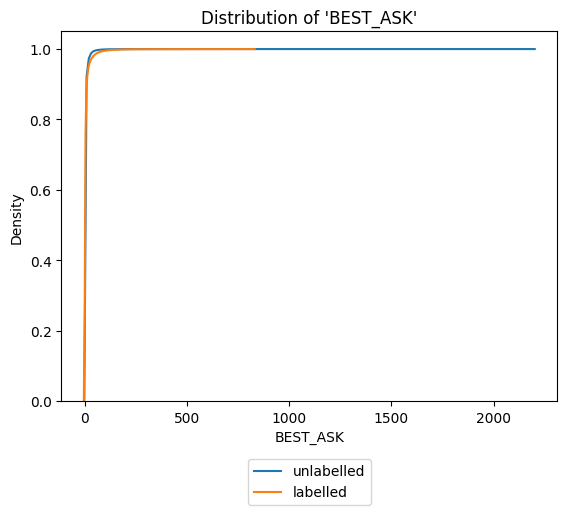

     unlabelled  labelled
0.1        0.20      0.12
0.2        0.40      0.30
0.3        0.63      0.55
0.4        0.91      0.90
0.5        1.27      1.36
0.6        1.77      2.05
0.7        2.50      3.16
0.8        3.90      5.10
0.9        7.70     10.20


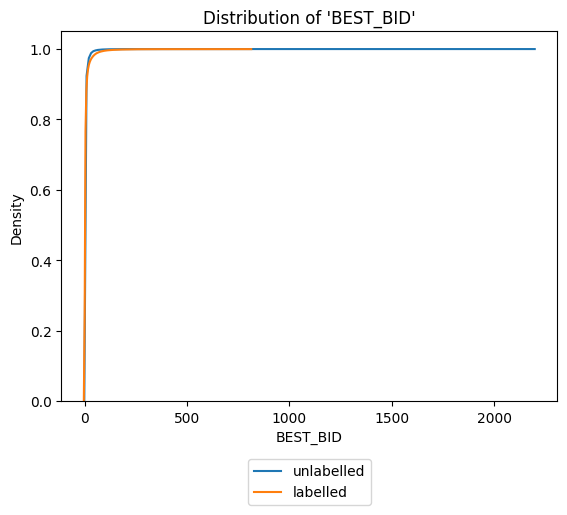

     unlabelled  labelled
0.1        0.16      0.07
0.2        0.36      0.25
0.3        0.59      0.50
0.4        0.87      0.82
0.5        1.22      1.27
0.6        1.70      1.95
0.7        2.42      3.00
0.8        3.75      4.85
0.9        7.50      9.85


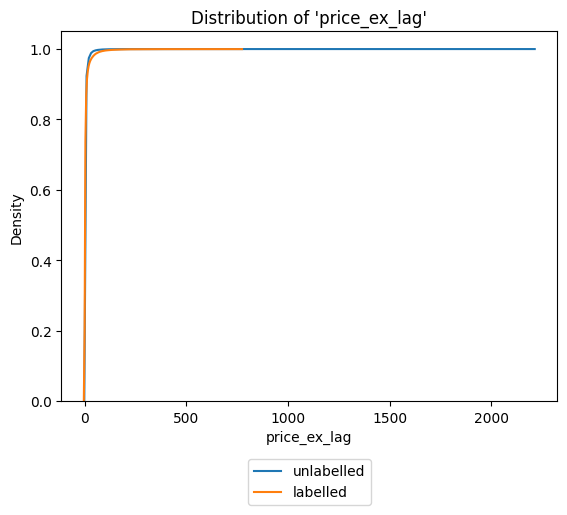

     unlabelled  labelled
0.1        0.19      0.15
0.2        0.39      0.34
0.3        0.62      0.60
0.4        0.90      0.95
0.5        1.26      1.40
0.6        1.75      2.08
0.7        2.47      3.12
0.8        3.83      5.00
0.9        7.60     10.06


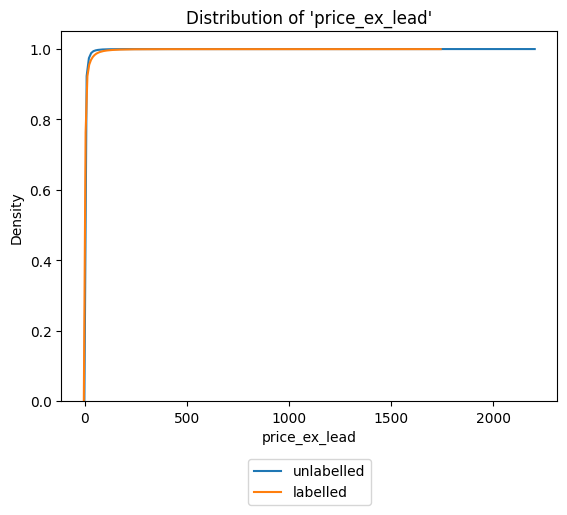

     unlabelled  labelled
0.1        0.18      0.13
0.2        0.38      0.31
0.3        0.61      0.56
0.4        0.90      0.91
0.5        1.25      1.37
0.6        1.74      2.06
0.7        2.46      3.12
0.8        3.81      5.05
0.9        7.59     10.27


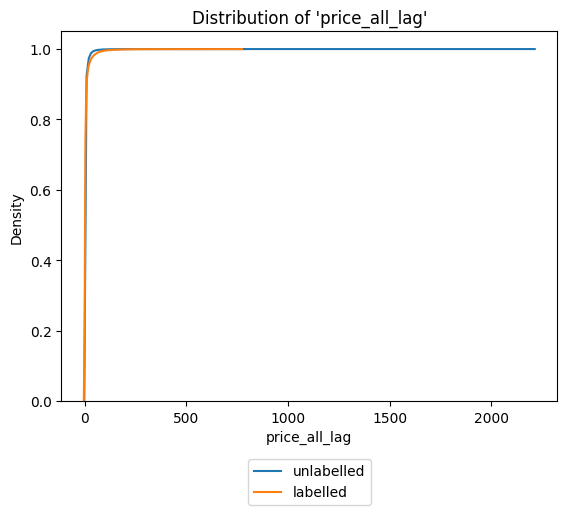

     unlabelled  labelled
0.1        0.19      0.12
0.2        0.38      0.30
0.3        0.61      0.55
0.4        0.90      0.89
0.5        1.25      1.35
0.6        1.75      2.02
0.7        2.46      3.10
0.8        3.81      5.00
0.9        7.60     10.00


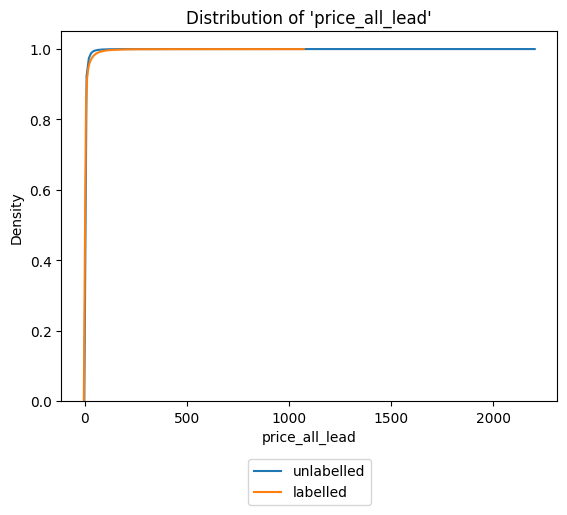

     unlabelled  labelled
0.1        0.18      0.12
0.2        0.38      0.30
0.3        0.61      0.55
0.4        0.90      0.90
0.5        1.25      1.35
0.6        1.75      2.05
0.7        2.47      3.10
0.8        3.81      5.00
0.9        7.60     10.11


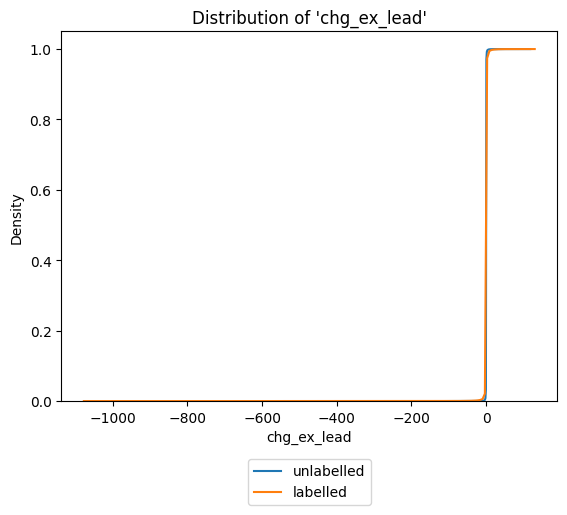

     unlabelled  labelled
0.1       -0.16 -0.570000
0.2       -0.05 -0.170000
0.3       -0.02 -0.050000
0.4       -0.01 -0.010000
0.5        0.01  0.010000
0.6        0.01  0.040000
0.7        0.03  0.100000
0.8        0.06  0.250000
0.9        0.18  0.690001


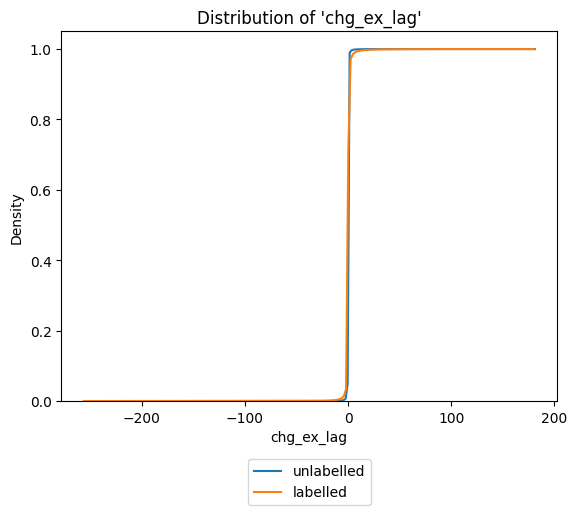

     unlabelled  labelled
0.1       -0.19     -0.64
0.2       -0.07     -0.24
0.3       -0.03     -0.10
0.4       -0.01     -0.04
0.5       -0.01     -0.01
0.6        0.01      0.01
0.7        0.02      0.05
0.8        0.05      0.16
0.9        0.16      0.60


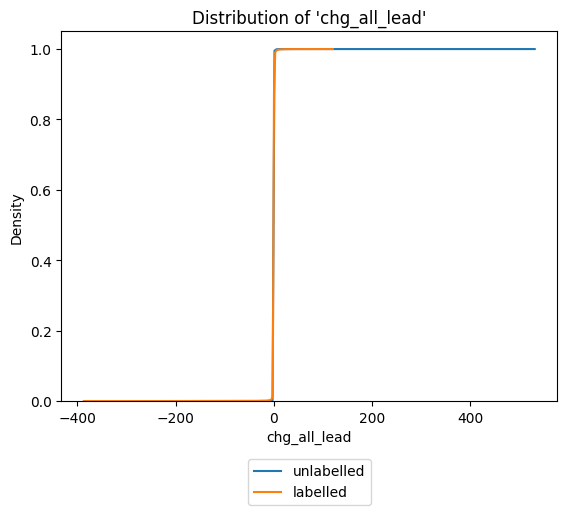

     unlabelled  labelled
0.1   -0.090000     -0.22
0.2   -0.040000     -0.07
0.3   -0.020000     -0.03
0.4   -0.010000     -0.01
0.5    0.009998      0.01
0.6    0.010000      0.01
0.7    0.020000      0.04
0.8    0.040000      0.09
0.9    0.090000      0.25


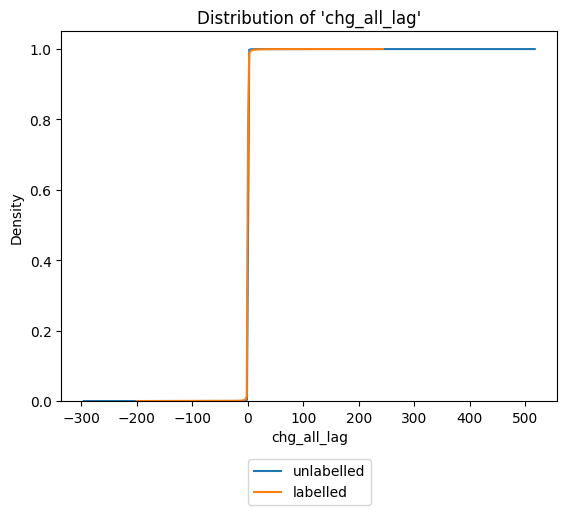

     unlabelled  labelled
0.1       -0.09     -0.25
0.2       -0.04     -0.09
0.3       -0.02     -0.04
0.4       -0.01     -0.02
0.5       -0.01     -0.01
0.6        0.01      0.01
0.7        0.02      0.03
0.8        0.03      0.07
0.9        0.08      0.22


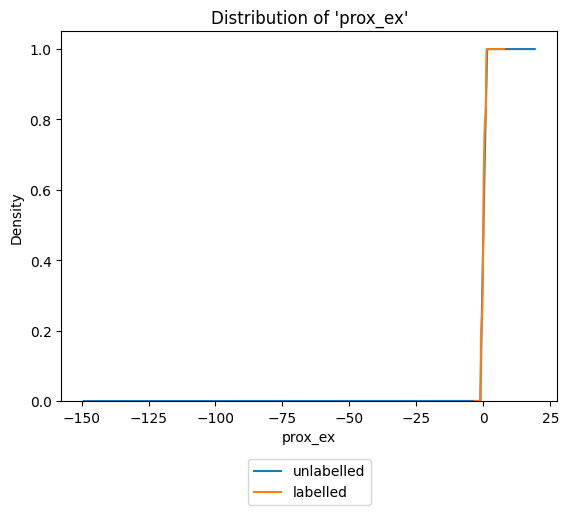

     unlabelled  labelled
0.1       -1.00 -1.000000
0.2       -1.00 -0.999976
0.3       -0.60 -0.333333
0.4       -0.20 -0.199966
0.5        0.00  0.000000
0.6        0.12  0.000001
0.7        0.50  0.200002
0.8        1.00  0.600000
0.9        1.00  1.000000


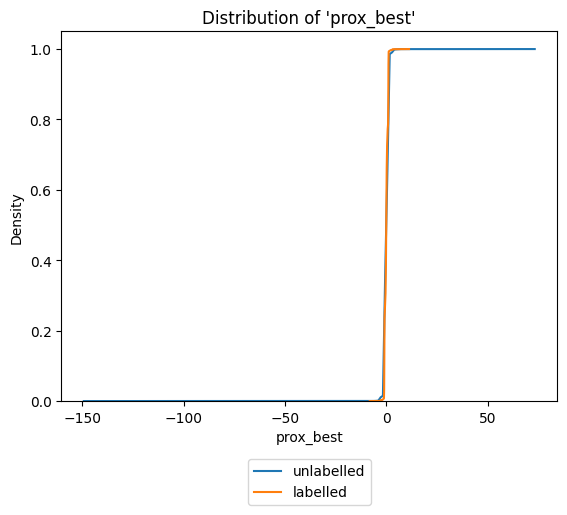

     unlabelled  labelled
0.1   -1.000000 -1.000000
0.2   -1.000000 -0.999999
0.3   -0.999998 -0.400000
0.4   -0.333333 -0.200000
0.5    0.000000  0.000000
0.6    0.200000  0.020000
0.7    0.999995  0.300000
0.8    1.000000  0.999998
0.9    1.000000  1.000000


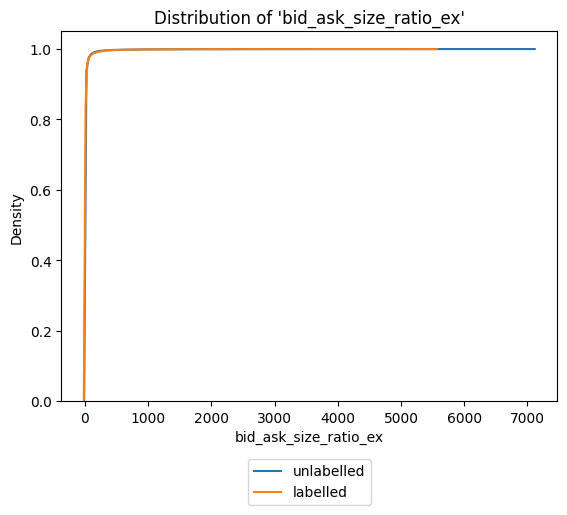

     unlabelled  labelled
0.1    0.068376  0.047619
0.2    0.205357  0.220000
0.3    0.403570  0.428571
0.4    0.656250  0.657895
0.5    1.000000  0.953678
0.6    1.431373  1.250000
0.7    2.270270  1.862745
0.8    4.300000  3.123886
0.9   11.666667  8.761905


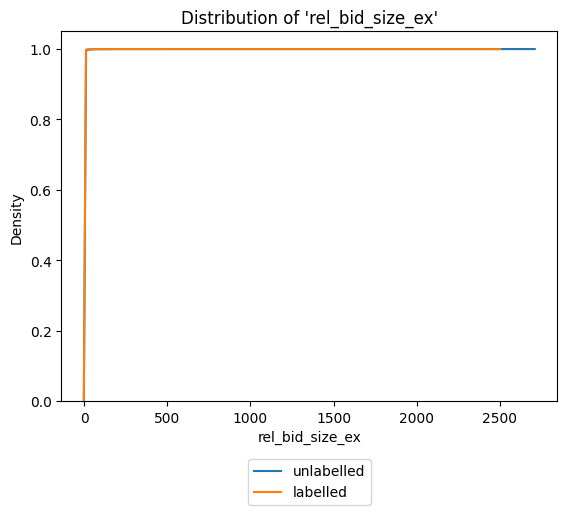

     unlabelled  labelled
0.1    0.012285  0.008030
0.2    0.027027  0.016667
0.3    0.047619  0.028571
0.4    0.083333  0.045455
0.5    0.136364  0.072464
0.6    0.238095  0.117647
0.7    0.454545  0.217391
0.8    1.000000  0.476190
0.9    1.000000  1.000000


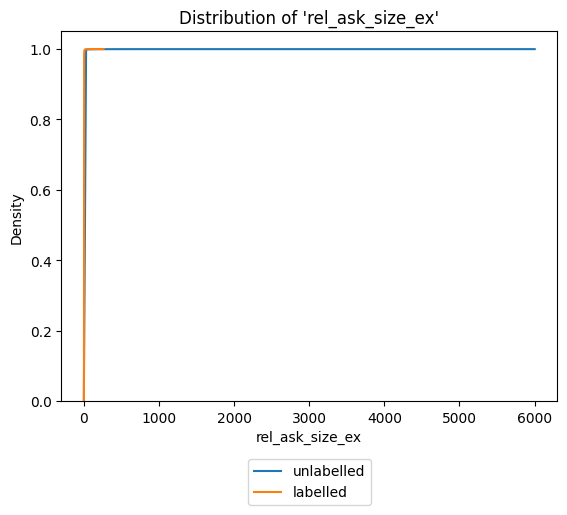

     unlabelled  labelled
0.1    0.012048  0.007519
0.2    0.026667  0.016000
0.3    0.047619  0.027100
0.4    0.083333  0.044776
0.5    0.136364  0.070968
0.6    0.238095  0.115385
0.7    0.464286  0.215686
0.8    1.000000  0.476190
0.9    1.000000  1.000000


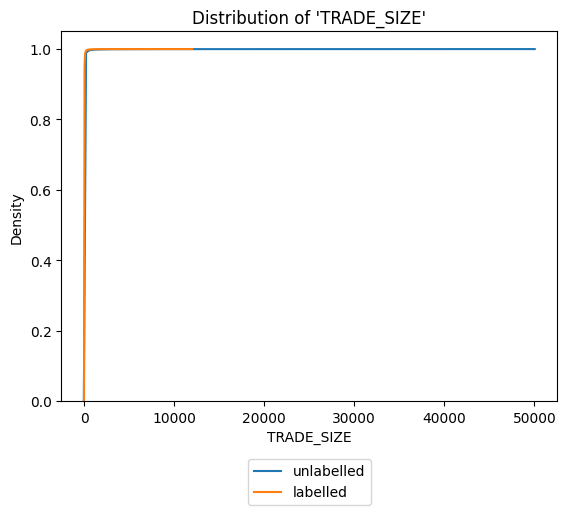

     unlabelled  labelled
0.1         1.0       1.0
0.2         1.0       1.0
0.3         2.0       1.0
0.4         3.0       2.0
0.5         5.0       3.0
0.6         7.0       5.0
0.7        10.0       9.0
0.8        14.0      10.0
0.9        30.0      23.0


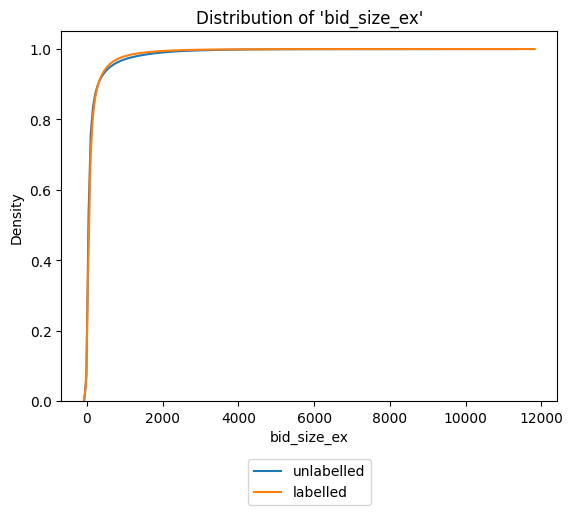

     unlabelled  labelled
0.1         5.0       5.0
0.2        10.0      17.0
0.3        18.0      24.0
0.4        25.0      35.0
0.5        35.0      48.0
0.6        50.0      66.0
0.7        74.0      94.0
0.8       126.0     149.0
0.9       294.0     298.0


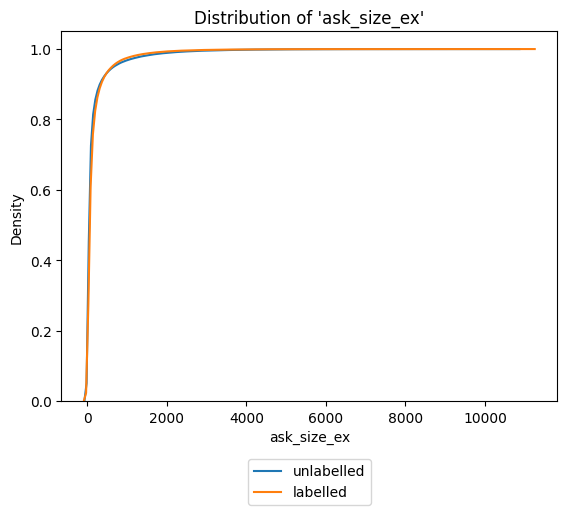

     unlabelled  labelled
0.1         5.0      10.0
0.2        10.0      21.0
0.3        20.0      31.0
0.4        26.0      40.0
0.5        36.0      53.0
0.6        51.0      72.0
0.7        75.0     104.0
0.8       130.0     168.0
0.9       313.0     342.0


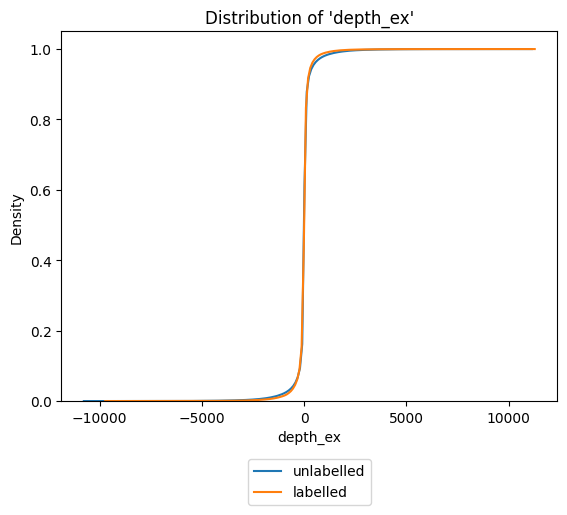

     unlabelled  labelled
0.1      -181.0    -198.0
0.2       -59.0     -78.0
0.3       -27.0     -38.0
0.4       -11.0     -18.0
0.5         0.0      -2.0
0.6        10.0      10.0
0.7        25.0      28.0
0.8        55.0      60.0
0.9       164.0     154.0


In [22]:
keys = data.columns.tolist()
keys.remove("buy_sell")
keys.remove("src")

for key in tqdm(keys):
    plot_kde_src(key)

## Proximity to Quotes

In [120]:
def plot_hist(unlabelled, labelled, title):
    fig, ax = plt.subplots()
    ax.hist(unlabelled, bins=50, alpha=0.5, label='unlabelled', density=True, range=[-2,2])
    ax.hist(labelled, bins=50, alpha=0.5, label='labelled', density=True, range=[-2,2])
    plt.title(title)
    plt.legend()
    plt.show()

In [121]:
var_name = "prox_ex"
unlabelled = data[data["src"] == "unlabelled"][var_name]
labelled = data[data["src"] == "labelled"][var_name]

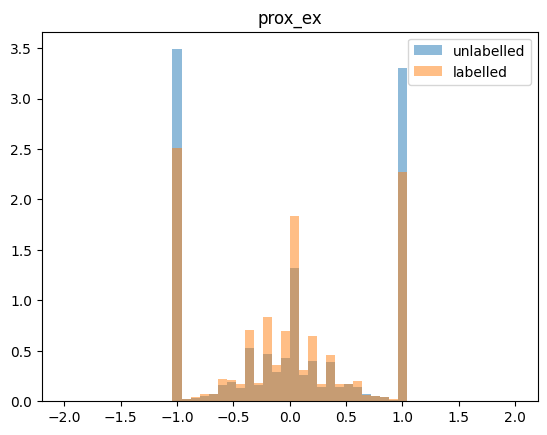

In [122]:
plot_hist(unlabelled, labelled, var_name)

In [134]:
var_name = "prox_best"
unlabelled = data[data["src"] == "unlabelled"][var_name]
labelled = data[data["src"] == "labelled"][var_name]

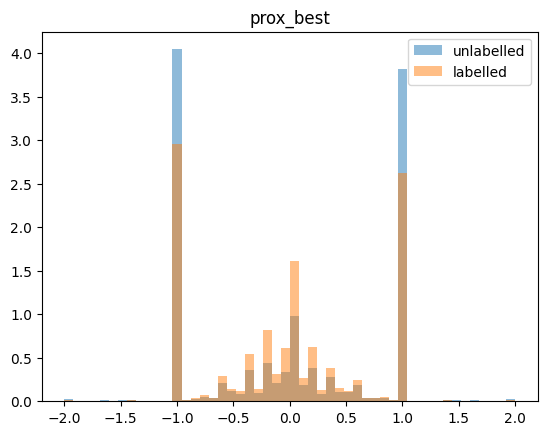

In [135]:
plot_hist(unlabelled, labelled, var_name)

## Bid Size == Trade Size || Ask Size == Trade Size

In [123]:
var_name = "rel_bid_size_ex"

unlabelled = data[data["src"] == "unlabelled"][var_name]
labelled = data[data["src"] == "labelled"][var_name]

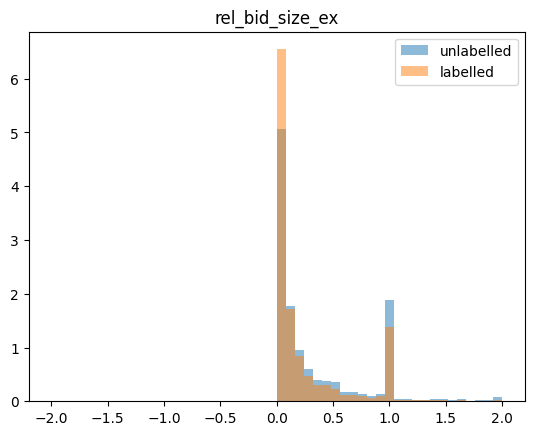

In [124]:
plot_hist(unlabelled, labelled, var_name)

In [125]:
var_name = "rel_ask_size_ex"

unlabelled = data[data["src"] == "unlabelled"][var_name]
labelled = data[data["src"] == "labelled"][var_name]

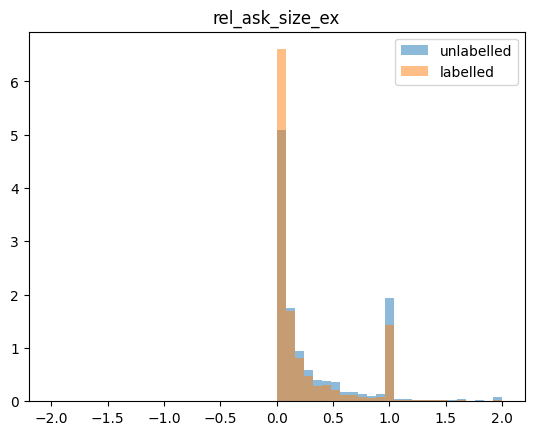

In [126]:
plot_hist(unlabelled, labelled, var_name)

## Absolute Spread

In [127]:
var_name = "spread"

data[var_name] = data["ask_ex"] - data["bid_ex"] 

In [128]:
unlabelled = data[data["src"] == "unlabelled"][var_name]
labelled = data[data["src"] == "labelled"][var_name]

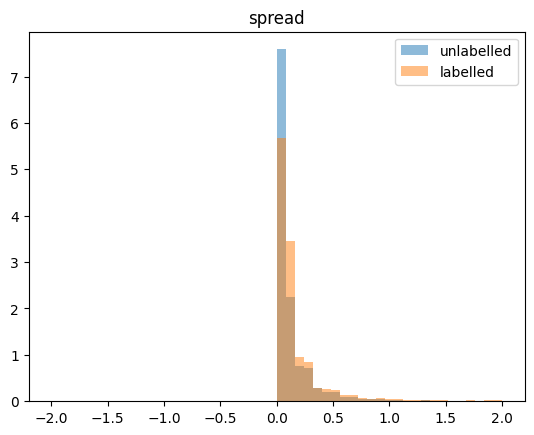

In [130]:
plot_hist(unlabelled, labelled, var_name)

## Delta to previous / next trade price

In [131]:
var_name = "prc_delta"
data[var_name] = (data["TRADE_PRICE"] - data["price_ex_lead"])

In [132]:
unlabelled = data[data["src"] == "unlabelled"][var_name]
labelled = data[data["src"] == "labelled"][var_name]

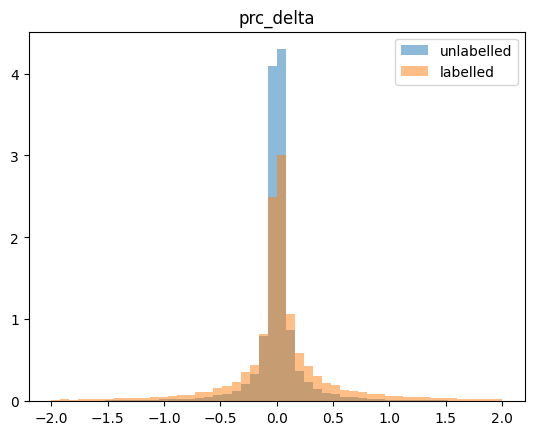

In [133]:
plot_hist(unlabelled, labelled, var_name)